In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Entropy of Real Cell

In [15]:
def Entropy(rstate, binnum, overlap = True):
    rstate[rstate>1] = 1
    wordsCollection = []
    if overlap:
        for i in np.arange(0,len(rstate)-binnum+1):
            wordsCollection.append(rstate[i:i+binnum])
    else:
        for i in np.arange(0,len(rstate)-binnum+1,binnum):
            wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    entropy = -np.sum(P*np.log2(P))
    return entropy

# Load Data and Check Input

In [16]:
dt = 0.01

annots = loadmat('D:\\GoogleDrive\\retina\\Exps\\2021\\1103\\SplitData\\diode_repeat_OU_tau=500ms_cutoff=1_mean=10_C=0.2_03-Nov-2021_0', squeeze_me = True)
sampling_rate = 20000
TimeStamps = annots['TimeStamps']
x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
x = x[::int(sampling_rate*dt)]
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
T = np.arange(len(x))*dt

Spike_Cell = [0]*60
for channelnumber in np.arange(1,61):
    Spike = annots['Spikes'][channelnumber-1]
    Spike_Cell[channelnumber-1] = Spike[np.where(Spike>TimeStamps[0])[0][0]:np.where(Spike<TimeStamps[1])[0][-1]]-TimeStamps[0]

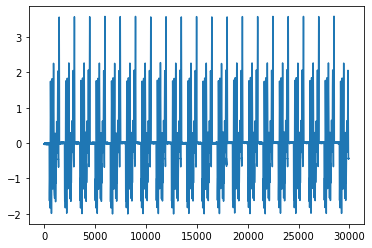

In [17]:
plt.plot(x)

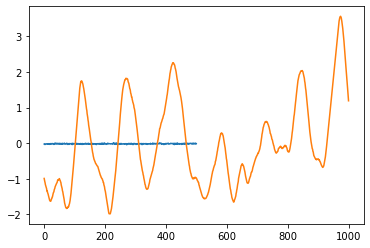

In [18]:
restTime = 5
stiTime = 10
trial = 20

plt.plot(x[:int(restTime/dt)])
plt.plot(x[int(restTime/dt):int((restTime+stiTime)/dt)])

# Information (R_info)

In [19]:
def R_info(rstate_trial, binnum, overlap = False):
    rstate_trial = np.array(rstate_trial)
    wordsCollection = []
    for rstate in rstate_trial:
        rstate[rstate>1] = 1
        if overlap:
            for i in np.arange(0,len(rstate)-binnum+1):
                wordsCollection.append(rstate[i:i+binnum])
        else:
            for i in np.arange(0,len(rstate)-binnum+1,binnum):
                wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    totalEntropy = -np.sum(P*np.log2(P))

    trial_num = rstate_trial.shape[0]
    event_num = int(len(wordsCollection)/rstate_trial.shape[0])

    subEntropy = 0
    for i in range(event_num):
        subSet = []
        for j in range(trial_num):
            subSet.append(wordsCollection[event_num*j+i])
        _, index = np.unique(np.array(subSet), axis = 0, return_inverse=True)
        N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
        P = N/np.sum(N)
        subEntropy += -np.sum(P*np.log2(P))
    
    noiseEntropy = subEntropy/event_num
    return totalEntropy, noiseEntropy

In [20]:
binLen = dt/10
binNum = 10

## Cut Trial (Stimulus)

In [21]:
totalEntropy_Cell = [0]*60
noiseEntropy_Cell = [0]*60
for ci in range(60):
    Spike = Spike_Cell[ci]

    Spike_Trial = [0]*trial
    rstate_Trial = [0]*trial
    for i in range(trial):
        startTime = restTime+i*(restTime+stiTime)
        endTime = (i+1)*(restTime+stiTime)
        try:
            Spike_Trial = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
            rstate_Trial[i], _ = np.histogram(Spike_Trial, np.arange(0,stiTime+binLen,binLen))
        except: # if there is no spike
            rstate_Trial[i] = np.zeros(int(stiTime/binLen)+1)

    totalEntropy_Cell[ci], noiseEntropy_Cell[ci] = R_info(rstate_Trial, binNum)
totalEntropy_Cell = np.array(totalEntropy_Cell)
noiseEntropy_Cell = np.array(noiseEntropy_Cell)

Text(0, 0.5, 'information (bit)')

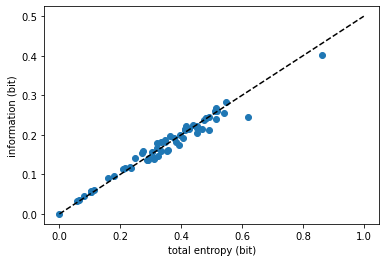

In [22]:
plt.scatter(totalEntropy_Cell,totalEntropy_Cell-noiseEntropy_Cell)
plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')

## Cut Trial (Rest)

In [23]:
rest_totalEntropy_Cell = [0]*60
rest_noiseEntropy_Cell = [0]*60
for ci in range(60):
    Spike = Spike_Cell[ci]

    Spike_Trial = [0]*trial
    rstate_Trial = [0]*trial
    for i in range(trial):
        startTime = i*(restTime+stiTime)
        endTime = restTime+i*(restTime+stiTime)
        try:
            Spike_Trial = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
            rstate_Trial[i], _ = np.histogram(Spike_Trial, np.arange(0,stiTime+binLen,binLen))
        except: # if there is no spike
            rstate_Trial[i] = np.zeros(int(stiTime/binLen)+1)

    rest_totalEntropy_Cell[ci], rest_noiseEntropy_Cell[ci] = R_info(rstate_Trial, binNum)
rest_totalEntropy_Cell = np.array(rest_totalEntropy_Cell)
rest_noiseEntropy_Cell = np.array(rest_noiseEntropy_Cell)

Text(0, 0.5, 'information (bit)')

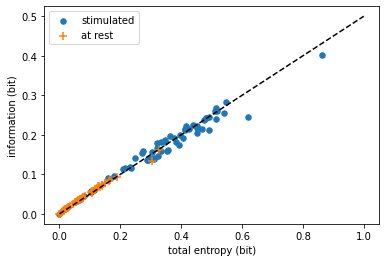

In [36]:
plt.scatter(totalEntropy_Cell,totalEntropy_Cell-noiseEntropy_Cell, label='stimulated', s = 30)
plt.scatter(rest_totalEntropy_Cell,rest_totalEntropy_Cell-rest_noiseEntropy_Cell, marker='+', label='at rest', s = 50)
plt.plot([0, 1.], [0, 0.5], 'k--')
plt.legend()
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')